### Experiment 4 - Fig 4 & Tbl 3

Proving that FedAvg and FAT model are very similar and can have only a small subset of layers affect robustness

In [1]:
cd /home/ubuntu/fedatk_unl_tj/

/home/ubuntu/fedatk_unl_tj


In [2]:
# Import General Libraries
import os
import argparse
import torch
import copy
import pickle
import random
import numpy as np
import pandas as pd
import gc

import torch.nn.functional as F
import re

# Import FedEM based Libraries
from utils.utils import *
from utils.constants import *
from utils.args import *
from utils.util_notebooks import *
from utils.util_notebooks import set_args, import_model_weights, get_adv_acc
from run_experiment import *
from models import *

# Import Transfer Attack
from transfer_attacks.Personalized_NN import *
from transfer_attacks.Params import *
from transfer_attacks.Transferer import *
from transfer_attacks.Args import *
from transfer_attacks.TA_utils import *





/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [3]:
# Specify aggregation method, number of clients, and dataset
setting, num_user = "FedAvg_adv", 20
exp = "celeba"

# Load models for FAT and FedAvg - write down path to where weights are saved
save_path_FAT = '/home/ubuntu/fedatk_unl_tj/weights/celeba/250123_icml25/FAT/'
save_path_FedAvg =  '/home/ubuntu/fedatk_unl_tj/weights/celeba/250123_icml25/FedAvg/'
# save_path_FAT = '/home/ubuntu/fedatk_unl_tj/weights/fakenews/250119_small_architecture_moreconv/FAT_ep02/'
# save_path_FedAvg =  '/home/ubuntu/fedatk_unl_tj/weights/fakenews/250119_small_architecture_moreconv/FedAvg/'

# Attack parameters for performing PGD 
eps_attack = 4.0
eps_train = 4.5
# eps_attack = 0.1
# eps_train = 0.2
step_size = 0.01
steps = 10

In [4]:
# Generate instance of aggregator that holds all clients, data and models and load relevant models in
try: # Skip loading if already loaded
    aggregator
except:
    aggregator, clients, args_ = set_args(setting, num_user,  experiment = exp) # Indicate dataset here

model_FAT = copy.deepcopy(import_model_weights(num_user, setting, save_path_FAT, aggregator, args_)[0])
model_Fedavg = copy.deepcopy(import_model_weights(num_user, setting, save_path_FedAvg, aggregator, args_)[0])

# Obtain parameters for each layer
params_FAT = model_FAT.state_dict()
params_FedAvg = model_Fedavg.state_dict()

# Just take the values of weights and bias for the model
desired_keys = params_FAT.keys() # [key for key in params_FAT.keys() if 'weight' in key or 'bias' in key] # 

==> Clients initialization..
===> Building data iterators..
get_celeba - Combining train batches... float16 version
get_celeba -Combining test batches... float16 version


 13%|█▎        | 19/150 [00:00<00:04, 32.64it/s]


===> Initializing clients..


  0%|          | 0/20 [00:00<?, ?it/s]/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 20/20 [00:05<00:00,  3.79it/s]
/home/ubuntu/fedatk_unl_tj/aggregator.py:289: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious p

In [5]:
x_min = torch.min(aggregator.clients[0].adv_nn.dataloader.x_data).detach().cuda()
x_max = torch.max(aggregator.clients[0].adv_nn.dataloader.x_data).detach().cuda()
import torch
import torch.nn.functional as F

def calculate_accuracy(model, x_data, y_data):
    """
    Calculate accuracy of a model on given data.

    Args:
        model: The model to evaluate (e.g., model_Fedavg or model_FAT).
        x_data: The input data (tensor).
        y_data: The ground truth labels (tensor).

    Returns:
        Accuracy as a percentage (float).
    """
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        # Forward pass
        outputs = model(x_data.cuda())  # Make sure input is on GPU
        _, predicted = torch.max(outputs, 1)  # Get the predicted class
        correct = (predicted == y_data.cuda()).sum().item()  # Count correct predictions
        accuracy = correct / len(y_data) * 100  # Calculate accuracy percentage
    return accuracy

c_id = 3

# Load client data
dataloader = load_client_data(clients=aggregator.clients, c_id=c_id, mode='test')
# x_data = copy.deepcopy(dataloader.x_data.to(torch.float32).cuda())  # Convert to float32 and move to GPU
# y_data = dataloader.y_data.cuda()  # Move ground truth to GPU

# Generate adversarial data (x_adv)
atk_params = PGD_Params()
atk_params.set_params(batch_size=50, iteration=steps,
                target=-1, x_val_min=x_min, x_val_max=x_max,
                step_size=step_size, step_norm="inf", eps=eps_attack, eps_norm=2)

combined_model = aggregator.clients[0].combine_learners_ensemble()
generator = Adv_NN(model_Fedavg, dataloader)

# Perform adversarial attack
generator.pgd(atk_params, print_info = True)
x_adv = generator.x_adv.to(torch.float32).cuda()  # Convert to float32 and move to GPU
x_data = generator.x_orig.to(torch.float32).cuda()
y_data = generator.y_orig.cuda()

generator2 = Adv_NN(model_FAT, dataloader)
generator.pgd(atk_params, print_info = True)

# Calculate accuracy for x_data and x_adv using model_Fedavg and model_FAT
accuracy_fedavg_x_data = calculate_accuracy(model_Fedavg, x_data, y_data)
accuracy_fedavg_x_adv = calculate_accuracy(model_Fedavg, x_adv, y_data)

accuracy_fat_x_data = calculate_accuracy(model_FAT, x_data, y_data)
accuracy_fat_x_adv = calculate_accuracy(model_FAT, x_adv, y_data)

# Print out the results
print(f"Accuracy of model_Fedavg on clean data (x_data): {accuracy_fedavg_x_data:.2f}%")
print(f"Accuracy of model_Fedavg on adversarial data (x_adv): {accuracy_fedavg_x_adv:.2f}%")

print(f"Accuracy of model_FAT on clean data (x_data): {accuracy_fat_x_data:.2f}%")
print(f"Accuracy of model_FAT on adversarial data (x_adv): {accuracy_fat_x_adv:.2f}%")


---- FGSM Batch Size: 50 ----

Orig Target: [6, 0, 8, 4, 0, 13, 4, 8, 8, 8, 0, 8, 12, 14, 10, 12, 4, 0, 4, 5, 8, 8, 0, 0, 12, 8, 12, 12, 8, 4, 12, 4, 4, 8, 8, 12, 4, 6, 0, 12, 8, 4, 4, 12, 8, 0, 4, 0, 0, 0]
Orig Output: [6, 0, 8, 5, 0, 13, 4, 8, 8, 8, 0, 8, 12, 12, 10, 12, 4, 0, 4, 5, 8, 8, 0, 0, 12, 8, 12, 4, 8, 1, 12, 4, 4, 8, 8, 12, 4, 6, 0, 12, 8, 4, 4, 12, 8, 0, 0, 0, 0, 0]
ADV Output : [4, 14, 9, 13, 14, 8, 10, 2, 4, 0, 12, 10, 0, 4, 5, 0, 9, 4, 12, 8, 15, 12, 12, 9, 0, 1, 4, 1, 0, 2, 14, 7, 8, 1, 0, 1, 8, 1, 8, 8, 4, 8, 9, 6, 0, 6, 9, 12, 10, 8] 

Orig Loss  : -14.453474998474121
ADV Loss   : 5.225202560424805 

Orig Acc   : 0.8999999761581421
ADV Acc    : 0.0
---- FGSM Batch Size: 50 ----

Orig Target: [4, 13, 8, 8, 0, 4, 0, 8, 8, 8, 0, 5, 4, 0, 12, 0, 4, 8, 8, 8, 12, 4, 8, 0, 0, 8, 8, 0, 0, 4, 12, 8, 0, 0, 8, 8, 4, 5, 12, 4, 8, 0, 12, 0, 0, 0, 8, 0, 8, 0]
Orig Output: [4, 13, 8, 8, 0, 4, 0, 8, 8, 8, 0, 4, 4, 0, 12, 0, 4, 8, 0, 0, 12, 6, 8, 0, 0, 8, 0, 0, 0, 4, 12, 8, 0, 0, 8, 

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


Submodule Name                 Mean Cosine Similarity         Std Dev
features.0                               0.97710145      0.00526916 
features.1                               0.82941163      0.02300177 !!!
features.2                               0.81529832      0.02355380 !!!
features.3                               0.82574606      0.01950816 !!!
features.4                               0.82021040      0.02407575 !!!
features.5                               0.80046517      0.02580082 !!!
features.6                               0.80458713      0.02688361 !!!
features.7                               0.80430019      0.02812876 !!!
features.8                               0.80907482      0.02420527 !!!
features.9                               0.79809064      0.02786407 !!!
features.10                              0.77584648      0.03398926 !!!
features.11                              0.75734937      0.03453816 !!!
features.12                              0.73703915      0.03850428 !

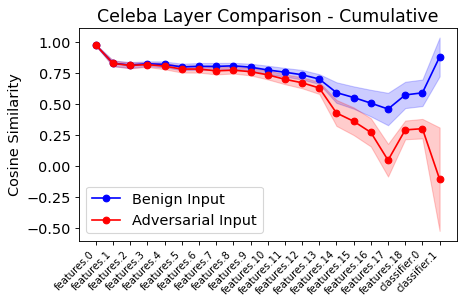

In [6]:
# Assuming the function compare_top_level_outputs_with_cosine_similarity is already defined as previously

# Example usage for Benign and Adversarial inputs
labs1, cs1, std_dev1 = compare_top_level_outputs_with_cosine_similarity(model_FAT, model_Fedavg, x_data.cuda())
labs2, cs2, std_dev2 = compare_top_level_outputs_with_cosine_similarity(model_FAT, model_Fedavg, x_adv.cuda())
# labs1, cs1, std_dev1 = compare_top_level_outputs_with_cosine_similarity_fnn(model_FAT, model_Fedavg, x_data.cuda())
# labs2, cs2, std_dev2 = compare_top_level_outputs_with_cosine_similarity_fnn(model_FAT, model_Fedavg, x_adv.cuda())

# Plotting setup
font = {'family': 'normal', 'weight': 'normal', 'size': 13}
threshold = 0.95

# Set font and figure size
plt.rc('font', **font)
plt.figure(dpi=80, figsize=(6, 4))

# Plot Cosine Similarities for both sets of inputs
line_color1 = 'b'  # Color for benign input
line_color2 = 'r'  # Color for adversarial input

plt.plot(labs1, cs1, marker="o", color=line_color1, label="Benign Input")
plt.plot(labs2, cs2, marker="o", color=line_color2, label="Adversarial Input")

# Overlay standard deviation ranges with matching colors
plt.fill_between(labs1, 
                 np.array(cs1) - std_dev1, 
                 np.array(cs1) + std_dev1, 
                 color=line_color1, alpha=0.2)

plt.fill_between(labs2, 
                 np.array(cs2) - std_dev2, 
                 np.array(cs2) + std_dev2, 
                 color=line_color2, alpha=0.2)

# Add threshold line (optional)
# plt.axhline(y=threshold, color="r", linestyle="--", label=f"Threshold = {threshold}")

# Plot settings
plt.xticks(rotation=45, ha="right", fontsize=9)
plt.ylabel("Cosine Similarity")
plt.title("Celeba Layer Comparison - Cumulative")
plt.legend()
plt.tight_layout()

# Display the plot
plt.show()

Submodule Name                 Mean Cosine Similarity         Std Dev
features.0                               0.97710145      0.00526916 
features.1                               0.89640427      0.00791742 !!!
features.2                               0.89895523      0.01551565 !!!
features.3                               0.96350563      0.00400216 
features.4                               0.94457030      0.00337369 !!!
features.5                               0.98323303      0.00112574 
features.6                               0.98920971      0.00060818 
features.7                               0.96132213      0.00293425 
features.8                               0.97923839      0.00245047 
features.9                               0.98827446      0.00157931 
features.10                              0.98310059      0.00854248 
features.11                              0.96764249      0.00185924 
features.12                              0.96803784      0.00364500 
features.13             

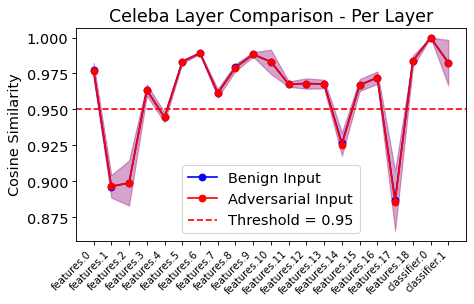

In [7]:

# Example usage for benign and adversarial inputs
labs1, cs1, std_dev1 = compare_intermediate_outputs_with_cosine_similarity(model_FAT, model_Fedavg, x_data.cuda())
labs2, cs2, std_dev2 = compare_intermediate_outputs_with_cosine_similarity(model_FAT, model_Fedavg, x_adv.cuda())

# labs1, cs1, std_dev1 = compare_intermediate_outputs_with_cosine_similarity_fnn(model_FAT, model_Fedavg, x_data.cuda())
# labs2, cs2, std_dev2 = compare_intermediate_outputs_with_cosine_similarity_fnn(model_FAT, model_Fedavg, x_adv.cuda())

# Plot cosine similarity with standard deviation range
font = {'family': 'normal', 'weight': 'normal', 'size': 13}
threshold = 0.95

# Set font and figure size
plt.rc('font', **font)
plt.figure(dpi=80, figsize=(6, 4))

# Plot the cosine similarity curves
line_color1 = 'b'  # Benign input curve color
line_color2 = 'r'  # Adversarial input curve color

plt.plot(labs1, cs1, marker="o", color=line_color1, label="Benign Input")
plt.plot(labs2, cs2, marker="o", color=line_color2, label="Adversarial Input")

# Overlay standard deviation as shaded regions
plt.fill_between(labs1, 
                 np.array(cs1) - std_dev1, 
                 np.array(cs1) + std_dev1, 
                 color=line_color1, alpha=0.2)

plt.fill_between(labs2, 
                 np.array(cs2) - std_dev2, 
                 np.array(cs2) + std_dev2, 
                 color=line_color2, alpha=0.2)

# Optional: Add threshold line
plt.axhline(y=threshold, color="r", linestyle="--", label=f"Threshold = {threshold}")

# Plot settings
plt.xticks(rotation=45, ha="right", fontsize=9)
plt.ylabel("Cosine Similarity")
plt.title("Celeba Layer Comparison - Per Layer")
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

In [8]:
model_Fedavg.state_dict().keys()

odict_keys(['features.0.0.weight', 'features.0.1.weight', 'features.0.1.bias', 'features.0.1.running_mean', 'features.0.1.running_var', 'features.0.1.num_batches_tracked', 'features.1.conv.0.0.weight', 'features.1.conv.0.1.weight', 'features.1.conv.0.1.bias', 'features.1.conv.0.1.running_mean', 'features.1.conv.0.1.running_var', 'features.1.conv.0.1.num_batches_tracked', 'features.1.conv.1.weight', 'features.1.conv.2.weight', 'features.1.conv.2.bias', 'features.1.conv.2.running_mean', 'features.1.conv.2.running_var', 'features.1.conv.2.num_batches_tracked', 'features.2.conv.0.0.weight', 'features.2.conv.0.1.weight', 'features.2.conv.0.1.bias', 'features.2.conv.0.1.running_mean', 'features.2.conv.0.1.running_var', 'features.2.conv.0.1.num_batches_tracked', 'features.2.conv.1.0.weight', 'features.2.conv.1.1.weight', 'features.2.conv.1.1.bias', 'features.2.conv.1.1.running_mean', 'features.2.conv.1.1.running_var', 'features.2.conv.1.1.num_batches_tracked', 'features.2.conv.2.weight', 'fea

In [9]:
def generate_model_with_copied_layers(model1, model2, layers_to_copy):
    """
    Generate a new model by copying specified layers from model1 to model2.
    
    Args:
        model1 (torch.nn.Module): The source model.
        model2 (torch.nn.Module): The base model to copy layers into.
        layers_to_copy (list of str): List of prefixes indicating which layers to copy.
    
    Returns:
        torch.nn.Module: A new model with the specified layers copied from model1.
    """
    # Create a deep copy of model2 to preserve the original
    model3 = copy.deepcopy(model2)
    
    state_dict1 = model1.state_dict()
    state_dict3 = model3.state_dict()  # Get state_dict for the new model
    
    # Iterate through state_dict keys and check for matching prefixes
    for key in state_dict1.keys():
        if any(key.startswith(layer_prefix) for layer_prefix in layers_to_copy):
            if key in state_dict3:  # Ensure the key exists in model3
                print("copied key ", key)
                state_dict3[key] = state_dict1[key].clone()
    
    # Load the updated state_dict into model3
    model3.load_state_dict(state_dict3)
    
    return model3

In [10]:
if exp == 'cifar10':
    # layers_to_copy = ["features.1.", "features.2.", "features.3."]
    layers_to_copy = ["features.1.", "features.2.", "features.3", "features.4.", "features.14.", 'features.17.']
    # layers_to_copy = ["features"]
    model_copied = generate_model_with_copied_layers(model_Fedavg, model_FAT, layers_to_copy)
    # model_copied = generate_model_with_copied_layers(model_FAT, model_Fedavg, layers_to_copy)

if exp == 'cifar100':
    # layers_to_copy = ["features.1.", "features.2.", "features.3."]
    layers_to_copy = ["features.1.", "features.2.", "features.3", "features.4.", "features.14.", 'features.17.']
    model_copied = generate_model_with_copied_layers(model_Fedavg, model_FAT, layers_to_copy)

if exp == 'celeba':
    # layers_to_copy = ["features.1.", "features.2.", "features.3."]
    layers_to_copy = ["features.1.", "features.2.", "features.3", "features.4.", "features.14.", 'features.17.']
    model_copied = generate_model_with_copied_layers(model_Fedavg, model_FAT, layers_to_copy)

if exp == 'fakenewsnet':
    layers_to_copy = ["fc1."]
    # layers_to_copy = ["conv1", "conv2", "conv3"]
    model_copied = generate_model_with_copied_layers(model_Fedavg, model_FAT, layers_to_copy)

acc, adv_acc = get_adv_acc(aggregator, model_copied, eps=eps_attack, step_size = step_size, steps = steps)

print("Test acc: ", np.mean(acc), " (", np.std(acc),") ", "adv acc: ", np.mean(adv_acc)," (", np.std(adv_acc),") ")

copied key  features.1.conv.0.0.weight
copied key  features.1.conv.0.1.weight
copied key  features.1.conv.0.1.bias
copied key  features.1.conv.0.1.running_mean
copied key  features.1.conv.0.1.running_var
copied key  features.1.conv.0.1.num_batches_tracked
copied key  features.1.conv.1.weight
copied key  features.1.conv.2.weight
copied key  features.1.conv.2.bias
copied key  features.1.conv.2.running_mean
copied key  features.1.conv.2.running_var
copied key  features.1.conv.2.num_batches_tracked
copied key  features.2.conv.0.0.weight
copied key  features.2.conv.0.1.weight
copied key  features.2.conv.0.1.bias
copied key  features.2.conv.0.1.running_mean
copied key  features.2.conv.0.1.running_var
copied key  features.2.conv.0.1.num_batches_tracked
copied key  features.2.conv.1.0.weight
copied key  features.2.conv.1.1.weight
copied key  features.2.conv.1.1.bias
copied key  features.2.conv.1.1.running_mean
copied key  features.2.conv.1.1.running_var
copied key  features.2.conv.1.1.num_batc

In [11]:
exp

'celeba'